In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

from keras.models import Sequential 
from keras.layers import Dense  ,Dropout
from keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor ,ExtraTreesRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from scipy.stats import zscore

In [ ]:
DecisionTreeRegressor
RandomForestRegressor 
ExtraTreesRegressor 
KNeighborsRegressor
MLPRegressor

# Prepare

In [300]:
def _load_data():
    train=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Training set 2011-2015')
    train.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    train=train.drop(list(train[train.isna().any(axis=1)].index),axis=0)

    test=pd.read_excel('Data set - Tisa.xlsx',sheet_name='Testing set 2016-2019 ')
    test.columns=['temperature', 'solids', 'dissolved_oxygen', 'pH','electrical', 'NH4', 'NO2', 'NO3', 'TN', 'PO4P', 'BOD5']
    test=test.drop(list(test[test.isna().any(axis=1)].index),axis=0)

    print(train.shape,test.shape)
    return train , test

def _prepare_data(data):
    X_train=data.drop(['dissolved_oxygen'],axis=1)
    y_train=data.dissolved_oxygen
    return X_train , y_train


def _calc_corr(y_test,y_pred,sqrt=False):
    res=pd.DataFrame(y_pred,columns=['pred'])
    res['real']=y_test
    if sqrt:
        return np.sqrt(res.corr())
    else: return res.corr()

def _zscore(df):
    df_scaled=zscore(df,axis=1)
    return df_scaled

def _scale_data(X_train,y_train,X_test,y_test,same=False):
    X_scaler=StandardScaler()
    X_train_scaled=X_scaler.fit_transform(X_train)
    y_scaler=StandardScaler()
    y_train_scaled=y_scaler.fit_transform(np.array(y_train).reshape(-1,1))    
    if same:
        X_test_scaled=X_scaler.transform(X_test)
        y_test_scaled=y_scaler.transform(np.array(y_test).reshape(-1,1))

        return X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled
    else:
        X_test_scaler=StandardScaler()
        y_test_scaler=StandardScaler()
        X_test_scaled=X_test_scaler.fit_transform(X_test)
        y_test_scaled=y_test_scaler.fit_transform(np.array(y_test).reshape(-1,1))  
        return X_train_scaled,y_train_scaled,X_test_scaled,y_test_scaled    

#create a function to find outliers using IQR
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def _relative_error(y_test,y_pred):
    re=[]
    for item in range(len(y_test)):
        re.append((abs(y_test[item]-y_pred[item])/y_test[item])*100)
    return np.mean(re)

def _errors(y_test, y_pred):
    mse=mean_squared_error(y_test, y_pred)
    rmse=np.sqrt(mse)
    relative=_relative_error(y_test,y_pred)
    mae=mean_absolute_error(y_test, y_pred)
    corr=_calc_corr(y_test,y_pred,sqrt=False)
    sq_corr=r2_score(y_test,y_pred)
    print(f"mse: {mse}\nrmse: {rmse}\nrelative: {relative} %\nmae: {mae}\ncorr:{corr['real']['pred']}\nsq_corr:{sq_corr}\n")

def _drop_outliers(train,test):
    train=train[find_outliers_IQR(train).isna()].dropna()
    test=test[find_outliers_IQR(test).isna()].dropna()
    print(train.shape,test.shape)
    return train,test

def _augment_data(df,n=1000):
    #creating fake data
    fake=pd.DataFrame([list(range(1,len(df.columns)+1))],columns=df.columns,index=range(n))
    fake.columns
    for item in fake.columns:
        fake[item]=np.random.random(n)
    fake['fake']=np.ones(len(fake))
    # concatenate fake and real data
    df['fake']=np.zeros(len(df))
    temp=pd.concat([fake,df],axis=0)
    temp.reset_index(drop=True,inplace=True)
    # Augment data
    X=temp.drop(['fake'],axis=1)
    y=temp.fake
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    X['fake']=y
    temp=X[X.fake==0]
    temp.drop(['fake'],axis=1,inplace=True)
    temp.reset_index(drop=True,inplace=True)
    return temp

def _dataset_type(train, test, type='ds1'):
    if type=='ds1':
        train.drop(['solids','NO2', 'NO3', 'TN','BOD5'],axis=1,inplace=True)
        test.drop(['solids','NO2', 'NO3', 'TN','BOD5'],axis=1,inplace=True)
        return train , test
    elif type=='ds2':
        train.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4'],axis=1,inplace=True)
        test.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4'],axis=1,inplace=True)
        return train , test
    elif type=='ds3':
        train.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4','electrical'],axis=1,inplace=True)
        test.drop(['solids','NO2', 'NO3', 'TN','BOD5','NH4','electrical'],axis=1,inplace=True) 
        return train , test  

# data

In [316]:
# load
train,test=_load_data()

# dataset type
train , test = _dataset_type(train, test,type='ds1')

# drop outliers
train,test=_drop_outliers(train , test)

# z score standard 
train=_zscore(train)
test =_zscore(test)

# Augment data
# train=_augment_data(train,n=1000)
print(train.shape)

# train test and x y split
X_train , y_train=_prepare_data(train)
X_test , y_test =_prepare_data(test)

# standard scale data
# X_train , y_train,X_test , y_test =_scale_data(X_train , y_train,X_test , y_test)


(605, 11) (461, 11)
(466, 6) (339, 6)
(466, 6)


# Models

## Machine Learning

In [55]:
# model checkpoint
# - ExtraTreeRegressor
# - this model has r2=0.741
# joblib.dump(model, 'extratreereg.joblib.pkl', compress=9)
model= joblib.load('extratreereg.joblib.pkl')

In [ ]:
DecisionTreeRegressor
RandomForestRegressor 
ExtraTreesRegressor 
KNeighborsRegressor
MLPRegressor

In [322]:
model=MLPRegressor()
model.fit(X_train.values,y_train)
y_pred=model.predict(X_test)
_errors(y_test.values, y_pred)

mse: 0.0005276185966235143
rmse: 0.022969949861144978
relative: -4.212524123877741 %
mae: 0.01768269128678556
corr:-0.8722184192489691
sq_corr:-0.42656794793379493



## DL Model

Epoch 1/250
13/13 [==============================] - 1s 22ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 2/250
13/13 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/250
13/13 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/250
13/13 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/250
13/13 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 6/250
13/13 [==============================] - 0s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 7/250
13/13 [==============================] - 0s 7ms/step - loss: 0.9999 - val_loss: 0.9999
Epoch 8/250
13/13 [==============================] - 0s 7ms/step - loss: 0.9999 - val_loss: 0.9999
Epoch 9/250
13/13 [==============================] - 0s 7ms/step - loss: 0.9999 - val_loss: 0.9999
Epoch 10/250
13/13 [==============================] - 0s 7ms/step - loss: 0.9999 - val_loss: 0.9999
Epoch 11

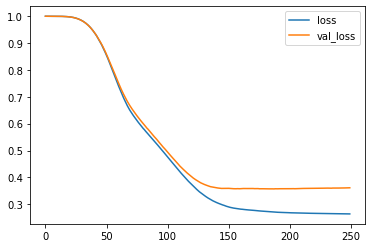

0.6388594421964744


,pred,real
pred,1.00,0.80
real,0.80,1.00


In [206]:
def _compile_model(X_train,y_train,X_test,y_test,epochs,batch_size):
    model = Sequential()
    model.add(Dense(15, input_shape=(X_train[0].shape[0],),kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(17,kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(10,kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(7,kernel_initializer='RandomNormal', activation='relu'))
    model.add(Dense(1,kernel_initializer='RandomNormal',activation='linear'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=Adam(0.0001))
    model.fit(X_train, y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test))
    
    history=model.history
    y_pred=model.predict(X_test)
    r2=r2_score(y_test,y_pred)
    return history , r2 , y_pred,model
history , r2 , y_pred,model=_compile_model(X_train,y_train,X_test,y_test,250,30)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
print(r2)
_calc_corr(y_test,y_pred)

## Hybrid model

In [90]:
model = Sequential()
model.add(Dense(15, input_shape=(X_train[0].shape[0],),kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(17,kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(20,kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(30,kernel_initializer='RandomNormal', activation='relu'))
model.add(Dense(40,kernel_initializer='RandomNormal',activation='linear'))

# Compile model
model.compile(loss='mean_squared_error', optimizer=Adam(0.0001))
model.fit(X_train, y_train,epochs=100,batch_size=30,validation_data=(X_test,y_test))


Epoch 1/100
167/167 [==============================] - 1s 4ms/step - loss: 0.9994 - val_loss: 0.9971
Epoch 2/100
167/167 [==============================] - 0s 3ms/step - loss: 0.9653 - val_loss: 0.9093
Epoch 3/100
167/167 [==============================] - 0s 3ms/step - loss: 0.7286 - val_loss: 0.5804
Epoch 4/100
167/167 [==============================] - 0s 3ms/step - loss: 0.3854 - val_loss: 0.4047
Epoch 5/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2792 - val_loss: 0.3753
Epoch 6/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2482 - val_loss: 0.3644
Epoch 7/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2288 - val_loss: 0.3589
Epoch 8/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2151 - val_loss: 0.3550
Epoch 9/100
167/167 [==============================] - 0s 3ms/step - loss: 0.2049 - val_loss: 0.3540
Epoch 10/100
167/167 [==============================] - 0s 3ms/step - loss: 0.1964 - val_lo

In [91]:
nnf_train=model.predict(X_train)
nnf_test=model.predict(X_test)
nnf_train.shape

9/9 [==============================] - 0s 2ms/step


(5000, 40)